In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import time
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import scipy.stats as stats
from scipy.stats import gamma
from scipy.stats import ortho_group

import cupy as cp
import cupyx.scipy 

from Test.hsic_naive import IndpTest_naive
from Test.hsic_lkgau import IndpTest_LKGaussian
from Test.hsic_lklap import IndpTest_LKLaplace
from Test.hsic_lkwgau import IndpTest_LKWeightGaussian
from Test.hsic_lkwlap import IndpTest_LKWeightLaplace
from Test.hsic_lkselect import IndpTest_LKSelect_GauLap
from Test.hsic_kselect import IndpTest_KSelect
from Test.dime_gaussian import IndpTest_DIME
from Test.mbmi_gaussian import IndpTest_kernelMI

device = torch.device('cuda:0')

In [2]:
def generate_ISA(n,d,sigma_normal,alpha, seed):
    np.random.seed(seed)
    x = np.concatenate((np.random.normal(-1, sigma_normal, n//2), np.random.normal(1, sigma_normal, n//2)))
    y = np.concatenate((np.random.normal(-1, sigma_normal, n//2), np.random.normal(1, sigma_normal, n//2)))
    p = np.random.permutation(n)
    y_p = y[p]

    D = np.zeros([2,n])
    D[0,:] = x
    D[1,:] = y_p

    theta = np.pi/4*alpha
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))

    D_R = R@D
    X_mix = D_R[0,:].reshape(-1,1)
    Y_mix = D_R[1,:].reshape(-1,1)

    X_z = np.random.randn(n,d-1)
    Y_z = np.random.randn(n,d-1)

    X_con = np.concatenate((X_mix,X_z), axis=1)
    Y_con = np.concatenate((Y_mix,Y_z), axis=1)

    m_x = ortho_group.rvs(dim=d)
    m_y = ortho_group.rvs(dim=d)

    X = (m_x@X_con.T).T
    Y = (m_y@Y_con.T).T
    
    return X,Y

def Sinusoid(x, y, w):
    return 1 + np.sin(w*x)*np.sin(w*y)

def Sinusoid_Generator(n,w):
    i = 0
    output = np.zeros([n,2])
    while i < n:
        U = np.random.rand(1)
        V = np.random.rand(2)
        x0 = -np.pi + V[0]*2*np.pi
        x1 = -np.pi + V[1]*2*np.pi
        if U < 1/2 * Sinusoid(x0,x1,w):
            output[i, 0] = x0
            output[i, 1] = x1
            i = i + 1
    return output

# n = 1000
# d = 3
def sinedependence(n,d,seed = 0):
    np.random.seed(seed)
    mean = np.zeros(d)
    cov = np.eye(d)
    X = np.random.multivariate_normal(mean, cov, n)
    Z = np.random.randn(n)
    Y = 20*np.sin(4*np.pi*(X[:,0]**2 + X[:,1]**2))+Z 
    return X,Y

# n = 1000
# d = 4
def GSign(n,d, seed):
    np.random.seed(seed)
    mean = np.zeros(d)
    cov = np.eye(d)
    X = np.random.multivariate_normal(mean, cov, n)
    sign_X = np.sign(X)
    Z = np.random.randn(n)
    Y = np.abs(Z)*np.prod(sign_X,1)
    return X,Y



Max DiME_n: 2.223302625941099
sigma_x: 0.5192472338676453, sigma_y: 42.89238357543945
Iteration: 0, DiME: 2.656226524691979
tensor([0.5192, 0.5192, 0.5192], device='cuda:0', dtype=torch.float64,
       grad_fn=<ExpBackward0>)
Iteration: 10, DiME: 2.256049767731669
tensor([0.4726, 0.4806, 0.5481], device='cuda:0', dtype=torch.float64,
       grad_fn=<ExpBackward0>)
Iteration: 20, DiME: 3.4274224878580735
tensor([0.4354, 0.4478, 0.5864], device='cuda:0', dtype=torch.float64,
       grad_fn=<ExpBackward0>)
Iteration: 30, DiME: 3.917330299422869
tensor([0.4075, 0.4163, 0.6275], device='cuda:0', dtype=torch.float64,
       grad_fn=<ExpBackward0>)
Iteration: 40, DiME: 3.627970323177355
tensor([0.3802, 0.3921, 0.6720], device='cuda:0', dtype=torch.float64,
       grad_fn=<ExpBackward0>)
Iteration: 50, DiME: 5.648634451382357
tensor([0.3536, 0.3782, 0.7039], device='cuda:0', dtype=torch.float64,
       grad_fn=<ExpBackward0>)
Iteration: 60, DiME: 3.8318353839949313
tensor([0.3246, 0.3758, 0.72

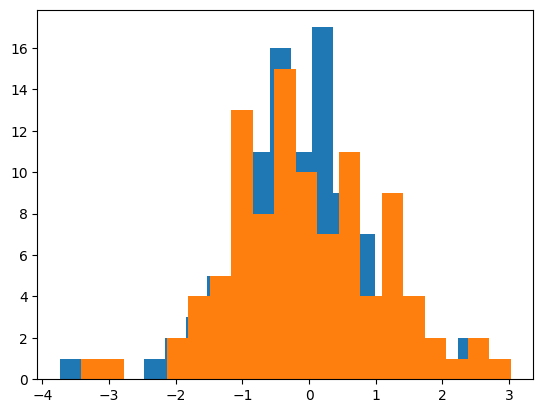

In [3]:
n = 900
d = 3
test_num = 2
dime_perm = 5
result_test_correct = np.zeros([6,test_num])
seed = 0 
for it in range(test_num):
    X, Y = sinedependence(n, d, seed)
    Y = Y.reshape(-1,1)
    X_tensor, Y_tensor = torch.tensor(X, device=device), torch.tensor(Y,device=device)

    #test#

  
    dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 10, alpha = 0.5, type_bandwidth="diagonal", lr = 0.01,  split_ratio = 0.5, 
                                    batch_size = None, grid_search_min = -1, grid_search_max = 4, epochs=300)
    results_dime = dime_estimator.perform_test()
    result_test_correct[0, it] = float(results_dime['h0_rejected'])
    print('Dime alpha = 1.0, diagonal kernel')
    print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected:' ,results_dime["h0_rejected"].item())
    print(dime_estimator.sigma_x_diag_vals)

    seed += 1
    print(it+1, np.sum(result_test_correct,1)/(it+1))

In [7]:
dime_estimator.sigma_x_diag_vals

tensor([0.1065, 0.0945, 0.2988], device='cuda:0', dtype=torch.float64)

In [74]:
sample_sizes = (300,600,900,1200)
n_samples = len(sample_sizes)
n_tests = 9
test_num = 5
result_test_correct = np.zeros([n_tests,n_samples, test_num])
print(result_test_correct.shape)

(9, 4, 5)


In [ ]:
n = 400
d = 4
test_num = 10

result_test_correct = np.zeros([6,test_num])
seed = 0 
for it in range(test_num):
    
    X, Y = GSign(n,d, seed)
    Y = Y.reshape(-1,1)
    X_tensor, Y_tensor = torch.tensor(X, device=device), torch.tensor(Y,device=device)

    #test#
    
    dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 5, alpha = 1.0, isotropic = True)
    results_dime = dime_estimator.perform_test()
    result_test_correct[0, it] = float(results_dime['h0_rejected'])
    print('Dime alpha = 1.0, isotropic kernel')
    print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected:' ,results_dime["h0_rejected"].item())

    dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 5, alpha = 1.0, isotropic = False)
    results_dime = dime_estimator.perform_test()
    result_test_correct[1, it] = float(results_dime['h0_rejected'])
    print('Dime alpha = 1.0, non-isotropic kernel')
    print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected' ,results_dime["h0_rejected"].item())

    dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 5, alpha = 2.0, isotropic = True)
    results_dime = dime_estimator.perform_test()
    result_test_correct[2, it] = float(results_dime['h0_rejected'])
    print('Dime alpha = 2.0, isotropic kernel')
    print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected' ,results_dime["h0_rejected"].item())

    dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 5, alpha = 2.0, isotropic = False)
    results_dime = dime_estimator.perform_test()
    result_test_correct[3, it] = float(results_dime['h0_rejected'])
    print('Dime alpha = 2.0, non-isotropic kernel')
    print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected' ,results_dime["h0_rejected"].item())

    dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 5, alpha = 5.0, isotropic = True)
    results_dime = dime_estimator.perform_test()
    result_test_correct[4, it] = float(results_dime['h0_rejected'])
    print('Dime alpha = 5.0, isotropic kernel')
    print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected' ,results_dime["h0_rejected"].item())

    dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 5, alpha = 5.0, isotropic = False)
    results_dime = dime_estimator.perform_test()
    result_test_correct[5, it] = float(results_dime['h0_rejected'])
    print('Dime alpha = 5.0, non-isotropic kernel')
    print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected' ,results_dime["h0_rejected"].item())

    seed += 1
    print(it+1, np.sum(result_test_correct,1)/(it+1))

Max DiME_n: 5.391734515116191
sigma_x: 1.6016240119934082, sigma_y: 5.467808723449707
Iteration: 0, DiME: 4.901511303610039
Iteration: 10, DiME: 4.092671585557313
Iteration: 20, DiME: 6.063638895717039
Iteration: 30, DiME: 4.630372030032884
Iteration: 40, DiME: 4.767160324448387
Iteration: 50, DiME: 8.056728720620027
Iteration: 60, DiME: 9.601806455169248
Iteration: 70, DiME: 8.571168468996031
Iteration: 80, DiME: 6.217434312624659
Iteration: 90, DiME: 5.293345753558041
Iteration: 100, DiME: 5.09042905671663
Iteration: 110, DiME: 7.960590657116388
Iteration: 120, DiME: 7.843045391786697
Iteration: 130, DiME: 7.059370415222917
Iteration: 140, DiME: 11.69242203618688
Iteration: 150, DiME: 7.337990492821027
Iteration: 160, DiME: 4.987046596465108
Iteration: 170, DiME: 4.896070034626048
Iteration: 180, DiME: 6.439142075052021
Iteration: 190, DiME: 5.853255845668395
Dime alpha = 1.0, non-isotropic kernel
threshold:  2.1465065969992745 DiME 4.891781979969032 null rejected True
1 [0. 1. 0. 0.

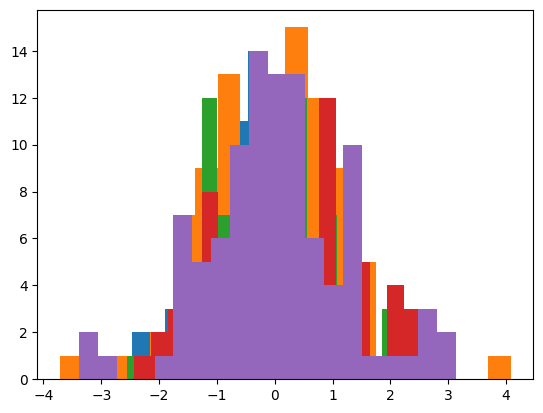

In [102]:
n = 700
d = 4
test_num = 5

result_test_correct = np.zeros([6,test_num])
seed = 0 
for it in range(test_num):
    
    X, Y = GSign(n,d, seed)
    Y = Y.reshape(-1,1)
    X_tensor, Y_tensor = torch.tensor(X, device=device), torch.tensor(Y,device=device)

    #test#
    
    # dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 5, alpha = 1.0, isotropic = True)
    # results_dime = dime_estimator.perform_test()
    # result_test_correct[0, it] = float(results_dime['h0_rejected'])
    # print('Dime alpha = 1.0, isotropic kernel')
    # print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected:' ,results_dime["h0_rejected"].item())

    dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 10 , alpha = 0.5, isotropic = False)
    results_dime = dime_estimator.perform_test()
    result_test_correct[1, it] = float(results_dime['h0_rejected'])
    print('Dime alpha = 1.0, non-isotropic kernel')
    print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected' ,results_dime["h0_rejected"].item())

    seed += 1
    print(it+1, np.sum(result_test_correct,1)/(it+1))

In [93]:
torch.linspace(-2, 2, 5)

tensor([-2., -1.,  0.,  1.,  2.])

In [6]:
# ica experiments #

test_num = 100
result_all_correct = []

# alpha_set = np.linspace(0.0, 1.0, num=10)
alpha_set = [0.7]

confident_level = 0.05

for alpha in alpha_set:
    result_test_correct = np.zeros([3,test_num])
    
    for it in range(test_num):
        n = 128
        d = 4
        sigma_normal = 0.1
        X, Y = generate_ISA(n,d,sigma_normal,alpha)
        X_tensor, Y_tensor = torch.tensor(X), torch.tensor(Y)
        
        #test#
        hsic0 = IndpTest_naive(X_tensor, Y_tensor, alpha=0.05, n_permutation=100, kernel_type="Gaussian", null_gamma = True)
        results_all0 = hsic0.perform_test()
        result_test_correct[0, it] = float(results_all0['h0_rejected'])

        hsic1 = IndpTest_LKGaussian(X_tensor, Y_tensor, device, alpha=0.05, n_permutation=100, null_gamma = True, split_ratio = 0.5)
        results_all1 = hsic1.perform_test(debug = -1, if_grid_search = True)
        result_test_correct[1, it] = float(results_all1['h0_rejected'])

        hsic2 = IndpTest_LKWeightGaussian(X_tensor, Y_tensor, device, alpha=0.05, n_permutation=100, null_gamma = True, split_ratio = 0.5)
        results_all2 = hsic2.perform_test(debug = -1, if_grid_search = True)
        result_test_correct[2, it] = float(results_all2['h0_rejected'])

        print(alpha, it, np.sum(result_test_correct,1)/(it+1))
    
    result_all_correct.append(result_test_correct)

0.7 0 [1. 1. 1.]
0.7 1 [0.5 0.5 1. ]
0.7 2 [0.33333333 0.33333333 1.        ]
0.7 3 [0.25 0.5  1.  ]
0.7 4 [0.2 0.4 0.8]
0.7 5 [0.16666667 0.33333333 0.83333333]
0.7 6 [0.14285714 0.28571429 0.85714286]
0.7 7 [0.125 0.25  0.875]
0.7 8 [0.11111111 0.22222222 0.88888889]
0.7 9 [0.1 0.3 0.9]
0.7 10 [0.09090909 0.27272727 0.90909091]
0.7 11 [0.08333333 0.25       0.91666667]
0.7 12 [0.07692308 0.30769231 0.92307692]
0.7 13 [0.14285714 0.35714286 0.92857143]
0.7 14 [0.13333333 0.33333333 0.93333333]
0.7 15 [0.125  0.3125 0.875 ]
0.7 16 [0.11764706 0.29411765 0.88235294]
0.7 17 [0.11111111 0.27777778 0.88888889]
0.7 18 [0.10526316 0.31578947 0.89473684]
0.7 19 [0.1 0.3 0.9]
0.7 20 [0.0952381  0.33333333 0.9047619 ]
0.7 21 [0.09090909 0.36363636 0.90909091]
0.7 22 [0.08695652 0.34782609 0.91304348]
0.7 23 [0.08333333 0.375      0.91666667]
0.7 24 [0.08 0.36 0.92]
0.7 25 [0.07692308 0.38461538 0.88461538]
0.7 26 [0.11111111 0.40740741 0.88888889]
0.7 27 [0.10714286 0.42857143 0.89285714]
0.7 2

0.5
Max DiME_n: 3.0514632445445757
sigma_x: 0.5817624926567078, sigma_y: 1.3217819929122925
Iteration: 0, DiME: 3.682119534269943
tensor([0.5818, 0.5818, 0.5818, 0.5818], device='cuda:0', dtype=torch.float64,
       grad_fn=<ExpBackward0>)
Iteration: 10, DiME: 3.7279419831608958
tensor([0.5571, 0.5406, 0.5711, 0.5771], device='cuda:0', dtype=torch.float64,
       grad_fn=<ExpBackward0>)
Iteration: 20, DiME: 8.953152635100045
tensor([0.5174, 0.4998, 0.5470, 0.5640], device='cuda:0', dtype=torch.float64,
       grad_fn=<ExpBackward0>)
Iteration: 30, DiME: 6.310970493899773
tensor([0.5079, 0.4809, 0.5326, 0.5393], device='cuda:0', dtype=torch.float64,
       grad_fn=<ExpBackward0>)
Iteration: 40, DiME: 7.247690415993975
tensor([0.4897, 0.4722, 0.5180, 0.5058], device='cuda:0', dtype=torch.float64,
       grad_fn=<ExpBackward0>)
Iteration: 50, DiME: 3.1013065599774285
tensor([0.4814, 0.4686, 0.5059, 0.4827], device='cuda:0', dtype=torch.float64,
       grad_fn=<ExpBackward0>)
Iteration: 60

KeyboardInterrupt: 

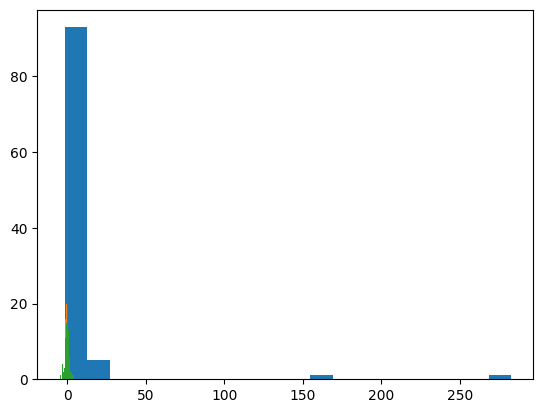

In [9]:

alphas = (0.5,)
alpha = alphas[0]
print(alpha)
n_alphas = len(alphas)
test_num = 5
dime_perm = 2
result_test_correct = np.zeros([2,test_num])
seed = 0 
sigma_normal = 0.1
n = 128
d = 4
for it in range(test_num):
    X, Y = generate_ISA(n,d,sigma_normal,alpha, seed)
    X_tensor, Y_tensor = torch.tensor(X, device=device), torch.tensor(Y,device=device)

    #test#
    
    # dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = dime_perm, alpha = 1.0, isotropic = True)
    # results_dime = dime_estimator.perform_test()
    # result_test_correct[0, it] = float(results_dime['h0_rejected'])
    # print('Dime alpha = 1.0, isotropic kernel')
    # print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected:' ,results_dime["h0_rejected"].item())

    dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 5, alpha =0.125, type_bandwidth="diagonal", epochs=200, lr= 0.01, grid_search_max=4, grid_search_min = -1)
    results_dime = dime_estimator.perform_test()
    result_test_correct[1, it] = float(results_dime['h0_rejected'])
    print('Dime alpha = 1.0, non-isotropic kernel')
    print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected' ,results_dime["h0_rejected"].item())

    # dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 5, alpha = 2.0, isotropic = True)
    # results_dime = dime_estimator.perform_test()
    # result_test_correct[2, it] = float(results_dime['h0_rejected'])
    # print('Dime alpha = 2.0, isotropic kernel')
    # print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected' ,results_dime["h0_rejected"].item())

    # dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 5, alpha = 2.0, isotropic = False)
    # results_dime = dime_estimator.perform_test()
    # result_test_correct[3, it] = float(results_dime['h0_rejected'])
    # print('Dime alpha = 2.0, non-isotropic kernel')
    # print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected' ,results_dime["h0_rejected"].item())

    # dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 5, alpha = 5.0, isotropic = True)
    # results_dime = dime_estimator.perform_test()
    # result_test_correct[4, it] = float(results_dime['h0_rejected'])
    # print('Dime alpha = 5.0, isotropic kernel')
    # print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected' ,results_dime["h0_rejected"].item())

    # dime_estimator = IndpTest_DIME( X_tensor, Y_tensor, dime_perm = 5, alpha = 5.0, isotropic = False)
    # results_dime = dime_estimator.perform_test()
    # result_test_correct[5, it] = float(results_dime['h0_rejected'])
    # print('Dime alpha = 5.0, non-isotropic kernel')
    # print('threshold: ',results_dime["thresh"].item(), 'DiME', results_dime["test_stat"].item(), 'null rejected' ,results_dime["h0_rejected"].item())

    # hsic0 = IndpTest_naive(X_tensor, Y_tensor, alpha=0.05, n_permutation=100, kernel_type="Gaussian", null_gamma = True)
    # results_all0 = hsic0.perform_test()
    # result_test_correct[0, it] = float(results_all0['h0_rejected'])

    # hsic1 = IndpTest_LKGaussian(X_tensor, Y_tensor, device, alpha=0.05, n_permutation=100, null_gamma = True, split_ratio = 0.5)
    # results_all1 = hsic1.perform_test(debug = -1, if_grid_search = True)
    # result_test_correct[1, it] = float(results_all1['h0_rejected'])

    # hsic2 = IndpTest_LKWeightGaussian(X_tensor, Y_tensor, device, alpha=0.05, n_permutation=100, null_gamma = True, split_ratio = 0.5)
    # results_all2 = hsic2.perform_test(debug = -1, if_grid_search = True)
    # result_test_correct[2, it] = float(results_all2['h0_rejected'])

    seed += 1
    print(it+1, np.sum(result_test_correct,1)/(it+1))